Import library

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from torchvision.transforms import v2
import torch.nn.functional as F
import matplotlib.pyplot as plt

EDA

In [ ]:
train_df_eda = pd.read_csv("train.csv")
val_df_eda = pd.read_csv("val.csv")

print("Train shape:", train_df_eda.shape)
print("Val shape:", val_df_eda.shape)

print("\nTrain columns / dtypes")
print(train_df_eda.dtypes)

print("\nTrain head()")
display(train_df_eda.head())

print("\nVal head()")
display(val_df_eda.head())


Train shape: (31546, 3)
Val shape: (24772, 3)

Train columns / dtypes
id           object
file_name    object
label         int64
dtype: object

Train head()


,id,file_name,label
0,PLY00001,su7tkav.jpg,0
1,PLY00002,shlk51f.jpg,4
2,PLY00003,sbdqvs0.jpg,0
3,PLY00004,s6oe1m9.jpg,2
4,PLY00005,skn51jb.jpg,0



Val head()


,id,file_name,label
0,VAL00001,st18mb9.jpg,4
1,VAL00002,sswbsm7.jpg,3
2,VAL00003,sfr46vb.jpg,1
3,VAL00004,sefug9r.jpg,2
4,VAL00005,soqw895.jpg,0


In [5]:
print("Missing values in train:")
print(train_df_eda.isnull().sum())

print("\nMissing values in val:")
print(val_df_eda.isnull().sum())

Missing values in train:
id           0
file_name    0
label        0
dtype: int64

Missing values in val:
id           0
file_name    0
label        0
dtype: int64


Train label counts:
label
0    12429
1     4407
2     5596
3     5926
4     3188
Name: count, dtype: int64

Val label counts:
label
0    3436
1    4194
2    6681
3    2912
4    7549
Name: count, dtype: int64


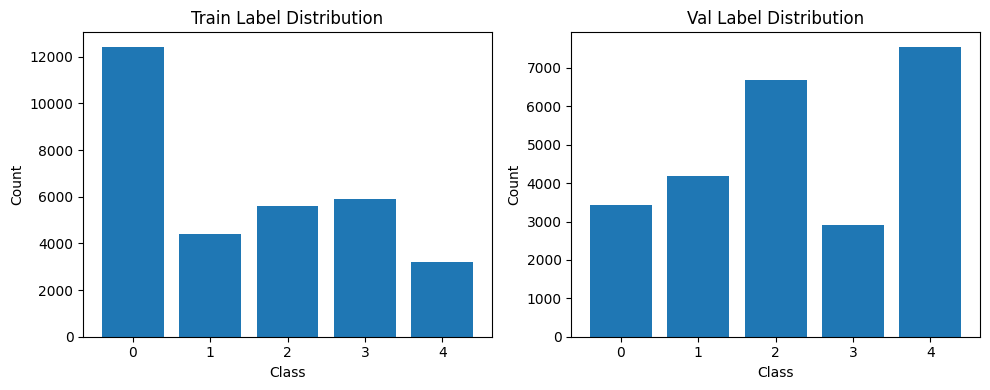

In [6]:
train_label_counts = train_df_eda['label'].value_counts().sort_index()
val_label_counts = val_df_eda['label'].value_counts().sort_index()

print("Train label counts:")
print(train_label_counts)
print("\nVal label counts:")
print(val_label_counts)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(train_label_counts.index, train_label_counts.values)
axes[0].set_title("Train Label Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

axes[1].bar(val_label_counts.index, val_label_counts.values)
axes[1].set_title("Val Label Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [12]:
train_img_dir = "train"
val_img_dir = "val"

def check_images_and_collect_sizes(df, img_dir, n_check=None):

    file_names = df['file_name'].tolist()
    if n_check is not None:
        file_names = file_names[:n_check]

    missing_files = []
    widths = []
    heights = []

    for fname in file_names:
        path = os.path.join(img_dir, fname)
        if not os.path.exists(path):
            missing_files.append(fname)
            continue

        try:
            img = Image.open(path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            img.close()
        except Exception as e:
            print(f"Error reading {path}: {e}")

    return missing_files, np.array(widths), np.array(heights)

train_missing, train_widths, train_heights = check_images_and_collect_sizes(
    train_df_eda, train_img_dir, n_check=None
)
val_missing, val_widths, val_heights = check_images_and_collect_sizes(
    val_df_eda, val_img_dir, n_check=None
)

print("Missing images in train:", len(train_missing))
print("Missing images in val:", len(val_missing))

if len(train_widths) > 0:
    print("Train image size (mean):", train_widths.mean(), "x", train_heights.mean())
if len(val_widths) > 0:
    print("Val image size (mean):", val_widths.mean(), "x", val_heights.mean())


Missing images in train: 0
Missing images in val: 0
Train image size (mean): 230.0 x 120.0
Val image size (mean): 230.0 x 120.0


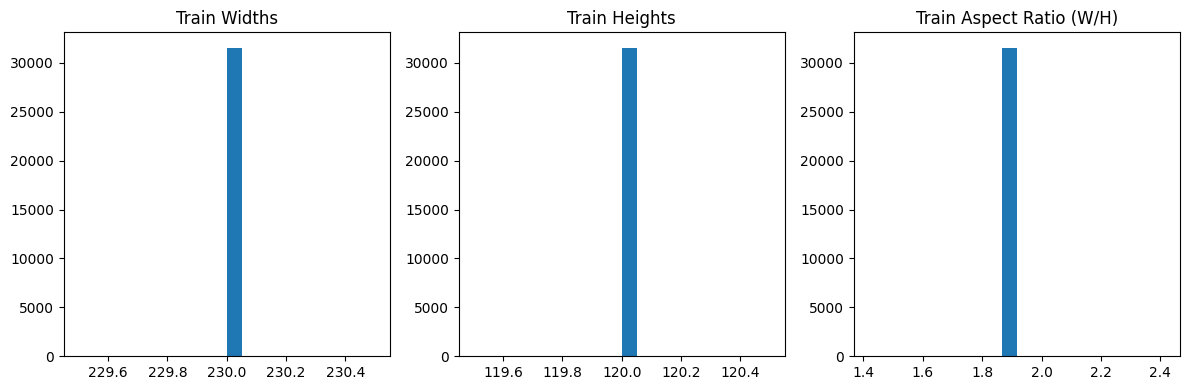

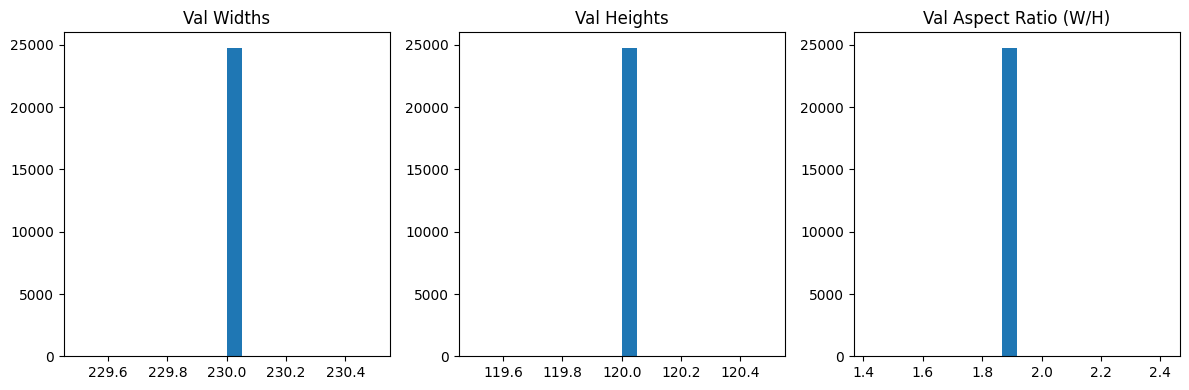

In [13]:
def plot_size_distribution(widths, heights, title_prefix="Train"):
    ratios = widths / heights

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(widths, bins=20)
    plt.title(f"{title_prefix} Widths")

    plt.subplot(1, 3, 2)
    plt.hist(heights, bins=20)
    plt.title(f"{title_prefix} Heights")

    plt.subplot(1, 3, 3)
    plt.hist(ratios, bins=20)
    plt.title(f"{title_prefix} Aspect Ratio (W/H)")

    plt.tight_layout()
    plt.show()

if len(train_widths) > 0:
    plot_size_distribution(train_widths, train_heights, "Train")

if len(val_widths) > 0:
    plot_size_distribution(val_widths, val_heights, "Val")


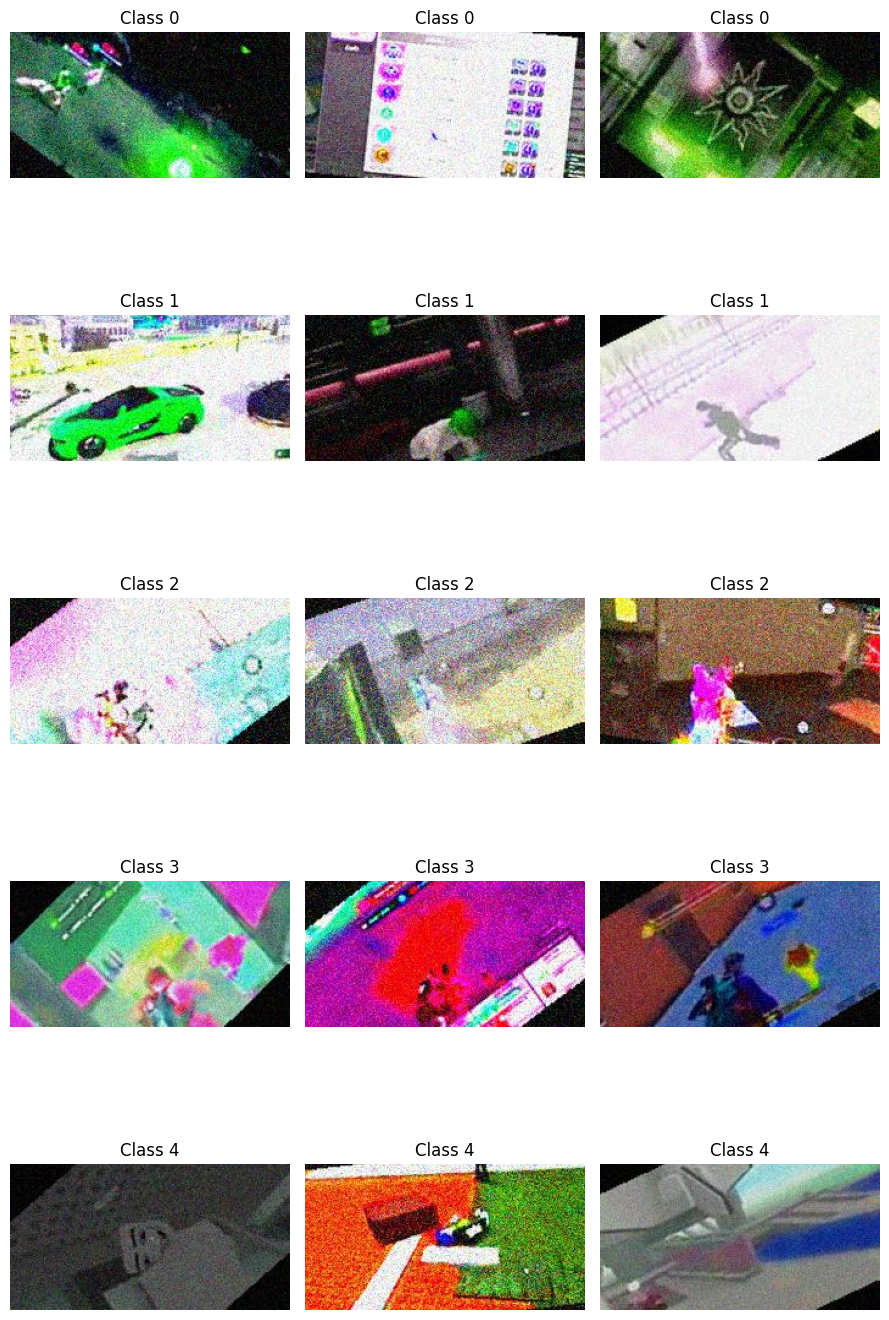

In [14]:
def show_examples_by_class(df, img_dir, n_per_class=3):
    labels = sorted(df['label'].unique())
    num_classes = len(labels)

    plt.figure(figsize=(n_per_class * 3, num_classes * 3))

    for row_idx, label in enumerate(labels):
        subset = df[df['label'] == label].head(n_per_class)
        for col_idx, (_, row) in enumerate(subset.iterrows()):
            img_path = os.path.join(img_dir, row['file_name'])
            try:
                img = Image.open(img_path).convert("RGB")
            except:
                continue

            plt_idx = row_idx * n_per_class + col_idx + 1
            plt.subplot(num_classes, n_per_class, plt_idx)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Class {label}")

    plt.tight_layout()
    plt.show()

show_examples_by_class(train_df_eda, train_img_dir, n_per_class=3)


Custom Class for Load Data

In [ ]:
class CSVLabelDataset_Train(Dataset):
    def __init__(self, csv_dir, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_dir)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx]['file_name'] 
        label = int(self.annotations.iloc[idx]['label'])     
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            raise e   
        if self.transform:
            image = self.transform(image)
            
        return image, label

class CSVLabelDataset_Test(Dataset):
    def __init__(self, csv_dir, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_dir)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx]['file_name'] 
        id = str(self.annotations.iloc[idx]['id'])
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            raise e   
        if self.transform:
            image = self.transform(image)
        
        return image, id

Model train

In [ ]:
#set model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

BATCH_SIZE = 32
PATIENCE = 8
epochs = 20

model = models.swin_t(weights='IMAGENET1K_V1')
model.head = torch.nn.Linear(model.head.in_features, 5)
model.to(device)

df = pd.read_csv('train.csv')

counts = df['label'].value_counts().sort_index()
class_weights = 1 / counts
class_weights = class_weights / class_weights.sum()
weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=PATIENCE)

scaler = torch.amp.GradScaler(device)

#set transform
imagenet_norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        imagenet_norm,
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        imagenet_norm,
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        imagenet_norm,
    ])
}

cutmix = v2.CutMix(num_classes=5)
mixup = v2.MixUp(num_classes=5)

cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

#load data
csv_files = {
    'train': 'train.csv',
    'val': 'val.csv', 
    'test': 'test.csv'
}

img_dirs = {
    'train': 'train/',
    'val': 'val/',
    'test': 'test/'
}

datasets = {
    x: CSVLabelDataset_Train(
        csv_dir=csv_files[x],
        img_dir=img_dirs[x], 
        transform=data_transforms[x]
    ) if x in ['train', 'val'] else CSVLabelDataset_Test(
        csv_dir=csv_files[x],
        img_dir=img_dirs[x],
        transform=data_transforms[x]
    ) for x in ['train', 'val', 'test']
}

dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=32,
        shuffle=(x == 'train'),  
    ) for x in ['train', 'val', 'test']
}

no_improve = 0
best_f1 = 0

#run epoch
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for imgs, labels in tqdm(dataloaders['train']):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        imgs, soft_labels = cutmix_or_mixup(imgs, labels)

        with torch.amp.autocast(device):
            outputs = model(imgs)
            log_softmax_outputs = F.log_softmax(outputs, dim=1)
            loss = F.kl_div(log_softmax_outputs, soft_labels, reduction='batchmean')

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloaders['val']):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    f1 = f1_score(trues, preds, average="macro")
    scheduler.step(f1)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss/len(dataloaders['train']):.4f} | "
          f"Val F1: {f1:.4f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(trues, preds)
    print(cm)

    with np.errstate(divide='ignore', invalid='ignore'):
      cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
      cm_norm = np.nan_to_num(cm_norm)

    print("\nNormalized Confusion Matrix (% per class):")
    print(cm_norm)

    if f1 > best_f1:
        best_f1 = f1
        no_improve = 0
        torch.save(model.state_dict(), "model.pth")
        print("Improved F1")

    else:
        no_improve += 1
        print(f"No improvement ({no_improve}/{PATIENCE})")

    if no_improve >= PATIENCE:
        print("Early stopped")
        break

print("Best Validation F1:", best_f1)

Using device: cuda


/tmp/ipython-input-2911425189.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.7228 | Val F1: 0.7032

Confusion Matrix:
[[3234   38  105   41   18]
 [ 180 3322  176  346  170]
 [ 247  110 3981 2182  161]
 [ 119  133  439 2086  135]
 [ 570  734  197 1264 4784]]

Normalized Confusion Matrix (% per class):
[[0.94121071 0.01105937 0.03055879 0.01193248 0.00523865]
 [0.04291845 0.79208393 0.04196471 0.08249881 0.0405341 ]
 [0.03697051 0.0164646  0.59586888 0.32659781 0.02409819]
 [0.04086538 0.04567308 0.15075549 0.71634615 0.04635989]
 [0.07550669 0.09723142 0.02609617 0.1674394  0.63372632]]
Improved F1


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.5781 | Val F1: 0.7071

Confusion Matrix:
[[3300   79   35   18    4]
 [ 134 3854   57   88   61]
 [ 364  271 4301 1594  151]
 [ 192  271  464 1850  135]
 [ 657 1488  233  758 4413]]

Normalized Confusion Matrix (% per class):
[[0.96041909 0.02299185 0.01018626 0.00523865 0.00116414]
 [0.03195041 0.91893181 0.01359084 0.02098236 0.01454459]
 [0.05448286 0.04056279 0.6437659  0.23858704 0.02260141]
 [0.06593407 0.09306319 0.15934066 0.6353022  0.04635989]
 [0.08703139 0.1971122  0.03086502 0.10041065 0.58458074]]
Improved F1


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.5400 | Val F1: 0.7220

Confusion Matrix:
[[3398    9   17    9    3]
 [ 310 3328  111  299  146]
 [ 550   56 4419 1512  144]
 [ 253   63  467 1999  130]
 [ 867  509  429  814 4930]]

Normalized Confusion Matrix (% per class):
[[9.88940629e-01 2.61932480e-03 4.94761350e-03 2.61932480e-03
  8.73108265e-04]
 [7.39151168e-02 7.93514545e-01 2.64663805e-02 7.12923224e-02
  3.48116357e-02]
 [8.23230055e-02 8.38197875e-03 6.61427930e-01 2.26313426e-01
  2.15536596e-02]
 [8.68818681e-02 2.16346154e-02 1.60370879e-01 6.86469780e-01
  4.46428571e-02]
 [1.14849649e-01 6.74261492e-02 5.68287190e-02 1.07828852e-01
  6.53066631e-01]]
Improved F1


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5048 | Val F1: 0.7293

Confusion Matrix:
[[3383   26   12    9    6]
 [ 182 3693   37  136  146]
 [ 518  131 4222 1433  377]
 [ 217  196  351 1803  345]
 [ 947  844  127  340 5291]]

Normalized Confusion Matrix (% per class):
[[0.98457509 0.00756694 0.00349243 0.00261932 0.00174622]
 [0.04339533 0.88054363 0.00882213 0.03242728 0.03481164]
 [0.0775333  0.01960784 0.63194133 0.21448885 0.05642868]
 [0.07451923 0.06730769 0.12053571 0.61916209 0.11847527]
 [0.12544708 0.11180289 0.01682342 0.04503908 0.70088753]]
Improved F1


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4871 | Val F1: 0.7506

Confusion Matrix:
[[3312   16   64   32   12]
 [ 151 3367  166  282  228]
 [ 235   33 4671 1542  200]
 [ 106   63  600 2006  137]
 [ 768  432  329  576 5444]]

Normalized Confusion Matrix (% per class):
[[0.96391153 0.00465658 0.01862631 0.00931315 0.00349243]
 [0.03600381 0.80281354 0.03958035 0.06723891 0.05436338]
 [0.03517438 0.00493938 0.69914683 0.23080377 0.02993564]
 [0.0364011  0.02163462 0.20604396 0.68887363 0.0470467 ]
 [0.10173533 0.05722612 0.04358193 0.0763015  0.72115512]]
Improved F1


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4758 | Val F1: 0.7363

Confusion Matrix:
[[3400   10   18    5    3]
 [ 221 3599   88  201   85]
 [ 491   51 4816 1138  185]
 [ 202   87  547 1954  122]
 [ 825  992  452  582 4698]]

Normalized Confusion Matrix (% per class):
[[9.89522701e-01 2.91036088e-03 5.23864959e-03 1.45518044e-03
  8.73108265e-04]
 [5.26943252e-02 8.58130663e-01 2.09823557e-02 4.79256080e-02
  2.02670482e-02]
 [7.34919922e-02 7.63358779e-03 7.20850172e-01 1.70333782e-01
  2.76904655e-02]
 [6.93681319e-02 2.98763736e-02 1.87843407e-01 6.71016484e-01
  4.18956044e-02]
 [1.09285998e-01 1.31408134e-01 5.98754802e-02 7.70963041e-02
  6.22334084e-01]]
No improvement (1/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.4596 | Val F1: 0.7856

Confusion Matrix:
[[3386    3   25    9   13]
 [ 235 3286  226  255  192]
 [ 217   18 5514  739  193]
 [ 124   39  614 1939  196]
 [ 581  423  558  346 5641]]

Normalized Confusion Matrix (% per class):
[[9.85448196e-01 8.73108265e-04 7.27590221e-03 2.61932480e-03
  3.78346915e-03]
 [5.60324273e-02 7.83500238e-01 5.38865045e-02 6.08011445e-02
  4.57796853e-02]
 [3.24801676e-02 2.69420745e-03 8.25325550e-01 1.10612184e-01
  2.88878910e-02]
 [4.25824176e-02 1.33928571e-02 2.10851648e-01 6.65865385e-01
  6.73076923e-02]
 [7.69638363e-02 5.60339118e-02 7.39170751e-02 4.58338853e-02
  7.47251292e-01]]
Improved F1


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.4431 | Val F1: 0.7594

Confusion Matrix:
[[3375    5   38   13    5]
 [ 166 3660  123  162   83]
 [ 216   56 5527  780  102]
 [  95   71  738 1935   73]
 [ 554 1150  851  508 4486]]

Normalized Confusion Matrix (% per class):
[[0.9822468  0.00145518 0.01105937 0.00378347 0.00145518]
 [0.03958035 0.87267525 0.02932761 0.03862661 0.01979018]
 [0.03233049 0.00838198 0.82727137 0.11674899 0.01526718]
 [0.03262363 0.02438187 0.25343407 0.66449176 0.02506868]
 [0.0733872  0.15233806 0.11273016 0.06729368 0.59425089]]
No improvement (1/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.4315 | Val F1: 0.7302

Confusion Matrix:
[[3404   10    9   10    3]
 [ 163 3622   54  227  128]
 [ 376   77 4058 2086   84]
 [ 126   75  293 2359   59]
 [ 721  791  352 1061 4624]]

Normalized Confusion Matrix (% per class):
[[9.90686845e-01 2.91036088e-03 2.61932480e-03 2.91036088e-03
  8.73108265e-04]
 [3.88650453e-02 8.63614688e-01 1.28755365e-02 5.41249404e-02
  3.05197902e-02]
 [5.62790001e-02 1.15252208e-02 6.07394103e-01 3.12228708e-01
  1.25729681e-02]
 [4.32692308e-02 2.57554945e-02 1.00618132e-01 8.10096154e-01
  2.02609890e-02]
 [9.55093390e-02 1.04782090e-01 4.66286925e-02 1.40548417e-01
  6.12531461e-01]]
No improvement (2/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.4286 | Val F1: 0.7815

Confusion Matrix:
[[3295    9  103   13   16]
 [ 107 3540  218  172  157]
 [ 149   42 5265 1077  148]
 [  53   56  638 2040  125]
 [ 386  589  691  538 5345]]

Normalized Confusion Matrix (% per class):
[[0.95896391 0.00261932 0.02997672 0.00378347 0.00465658]
 [0.02551264 0.84406295 0.05197902 0.04101097 0.03743443]
 [0.02230205 0.00628648 0.78805568 0.16120341 0.02215237]
 [0.01820055 0.01923077 0.21909341 0.70054945 0.04292582]
 [0.0511326  0.07802358 0.0915353  0.07126772 0.7080408 ]]
No improvement (3/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.4232 | Val F1: 0.7225

Confusion Matrix:
[[3389   12   15   15    5]
 [ 218 3698  115  118   45]
 [ 314   54 5239 1029   45]
 [ 153   68  606 2053   32]
 [ 915 1304  819  833 3678]]

Normalized Confusion Matrix (% per class):
[[0.9863213  0.00349243 0.00436554 0.00436554 0.00145518]
 [0.05197902 0.88173581 0.02742012 0.02813543 0.01072961]
 [0.04699895 0.00808262 0.78416405 0.15401886 0.00673552]
 [0.05254121 0.02335165 0.2081044  0.70501374 0.01098901]
 [0.12120811 0.17273811 0.10849119 0.11034574 0.48721685]]
No improvement (4/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.4166 | Val F1: 0.7912

Confusion Matrix:
[[3351    5   31   13   36]
 [ 150 3459  132  234  219]
 [ 220   28 5138 1066  229]
 [ 107   47  453 2144  161]
 [ 520  410  422  490 5707]]

Normalized Confusion Matrix (% per class):
[[0.97526193 0.00145518 0.00902212 0.00378347 0.0104773 ]
 [0.03576538 0.82474964 0.03147353 0.05579399 0.05221745]
 [0.0329292  0.00419099 0.76904655 0.15955695 0.03427631]
 [0.03674451 0.01614011 0.15556319 0.73626374 0.05528846]
 [0.0688833  0.05431183 0.05590144 0.06490926 0.75599417]]
Improved F1


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.4071 | Val F1: 0.7832

Confusion Matrix:
[[3341   32   44   15    4]
 [  92 3664   92  181  165]
 [ 206   70 4993 1191  221]
 [  71   98  496 2111  136]
 [ 448  720  486  451 5444]]

Normalized Confusion Matrix (% per class):
[[0.97235157 0.00931315 0.01280559 0.00436554 0.00116414]
 [0.0219361  0.87362899 0.0219361  0.04315689 0.03934192]
 [0.03083371 0.01047747 0.74734321 0.17826673 0.03307888]
 [0.02438187 0.03365385 0.17032967 0.72493132 0.0467033 ]
 [0.05934561 0.09537687 0.06437939 0.05974301 0.72115512]]
No improvement (1/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.4099 | Val F1: 0.7791

Confusion Matrix:
[[3374    5   33   19    5]
 [ 169 3367  190  280  188]
 [ 195   17 5334 1013  122]
 [ 100   42  611 2083   76]
 [ 521  445  611  642 5330]]

Normalized Confusion Matrix (% per class):
[[0.98195576 0.00145518 0.00960419 0.00552969 0.00145518]
 [0.04029566 0.80281354 0.04530281 0.06676204 0.04482594]
 [0.02918725 0.00254453 0.79838348 0.15162401 0.01826074]
 [0.03434066 0.01442308 0.20982143 0.71531593 0.0260989 ]
 [0.06901576 0.05894821 0.08093787 0.08504438 0.70605378]]
No improvement (2/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.3944 | Val F1: 0.7845

Confusion Matrix:
[[3421    6    4    4    1]
 [ 159 3719   39  141  136]
 [ 322   71 4635 1438  215]
 [ 102   81  401 2210  118]
 [ 592  665  193  453 5646]]

Normalized Confusion Matrix (% per class):
[[9.95634459e-01 1.74621653e-03 1.16414435e-03 1.16414435e-03
  2.91036088e-04]
 [3.79113019e-02 8.86742966e-01 9.29899857e-03 3.36194564e-02
  3.24272771e-02]
 [4.81963778e-02 1.06271516e-02 6.93758419e-01 2.15237240e-01
  3.21808113e-02]
 [3.50274725e-02 2.78159341e-02 1.37706044e-01 7.58928571e-01
  4.05219780e-02]
 [7.84209829e-02 8.80911379e-02 2.55663002e-02 6.00079481e-02
  7.47913631e-01]]
No improvement (3/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.3948 | Val F1: 0.7490

Confusion Matrix:
[[3416    6   12    1    1]
 [ 234 3647   59  132  122]
 [ 421   67 4979 1121   93]
 [ 141   75  505 2123   68]
 [ 932  837  455  767 4558]]

Normalized Confusion Matrix (% per class):
[[9.94179278e-01 1.74621653e-03 3.49243306e-03 2.91036088e-04
  2.91036088e-04]
 [5.57939914e-02 8.69575584e-01 1.40677158e-02 3.14735336e-02
  2.90891750e-02]
 [6.30145188e-02 1.00284389e-02 7.45247717e-01 1.67789253e-01
  1.39200718e-02]
 [4.84203297e-02 2.57554945e-02 1.73420330e-01 7.29052198e-01
  2.33516484e-02]
 [1.23460061e-01 1.10875613e-01 6.02728838e-02 1.01602861e-01
  6.03788581e-01]]
No improvement (4/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.3933 | Val F1: 0.7424

Confusion Matrix:
[[3396   14   11    7    8]
 [ 126 3777   59  157   75]
 [ 273   85 4569 1680   74]
 [  79   77  312 2383   61]
 [ 759  902  452 1189 4247]]

Normalized Confusion Matrix (% per class):
[[0.98835856 0.00407451 0.0032014  0.00203725 0.00232829]
 [0.03004292 0.90057225 0.01406772 0.03743443 0.01788269]
 [0.04086215 0.01272265 0.68387966 0.25145936 0.01107619]
 [0.02712912 0.02644231 0.10714286 0.81833791 0.0209478 ]
 [0.10054312 0.11948602 0.05987548 0.15750431 0.56259107]]
No improvement (5/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.3875 | Val F1: 0.7897

Confusion Matrix:
[[3386    8   29    6    7]
 [ 115 3771   84  116  108]
 [ 198   97 5063 1145  178]
 [  75   98  377 2243  119]
 [ 626  829  405  460 5229]]

Normalized Confusion Matrix (% per class):
[[0.9854482  0.00232829 0.00844005 0.00174622 0.00203725]
 [0.02742012 0.89914163 0.02002861 0.02765856 0.02575107]
 [0.02963628 0.01451878 0.75782069 0.17138153 0.02664272]
 [0.02575549 0.03365385 0.12946429 0.77026099 0.04086538]
 [0.08292489 0.10981587 0.05364949 0.06093522 0.69267453]]
No improvement (6/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.3860 | Val F1: 0.7833

Confusion Matrix:
[[3401    6   15    7    7]
 [ 188 3559  127  174  146]
 [ 360   34 5350  802  135]
 [ 125   48  526 2129   84]
 [ 557  673  575  595 5149]]

Normalized Confusion Matrix (% per class):
[[0.98981374 0.00174622 0.00436554 0.00203725 0.00203725]
 [0.04482594 0.84859323 0.03028135 0.04148784 0.03481164]
 [0.05388415 0.00508906 0.80077833 0.12004191 0.02020656]
 [0.04292582 0.01648352 0.18063187 0.73111264 0.02884615]
 [0.07378461 0.08915088 0.07616903 0.07881839 0.6820771 ]]
No improvement (7/8)


  0%|          | 0/986 [00:00<?, ?it/s]

/tmp/ipython-input-2911425189.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.3804 | Val F1: 0.7939

Confusion Matrix:
[[3380    6   20    8   22]
 [ 104 3595   96  235  164]
 [ 214   53 5069 1190  155]
 [  73   57  416 2246  120]
 [ 486  436  478  651 5498]]

Normalized Confusion Matrix (% per class):
[[0.98370198 0.00174622 0.00582072 0.00232829 0.00640279]
 [0.02479733 0.85717692 0.02288984 0.05603243 0.03910348]
 [0.03203113 0.00793294 0.75871875 0.17811705 0.02320012]
 [0.02506868 0.01957418 0.14285714 0.77129121 0.04120879]
 [0.06437939 0.05775599 0.06331964 0.08623659 0.72830839]]
Improved F1
Best Validation F1: 0.7939097491023525


Evaluation predict

In [ ]:
#eva
model = models.swin_t(weights='IMAGENET1K_V1')
model.head = torch.nn.Linear(model.head.in_features, 5)
model.load_state_dict(torch.load("model.pth"))
model.to(device) 
model.eval()

#predict
ans_ids =[]
y_preds = []
with torch.no_grad():
    for img, id in tqdm(dataloaders['test']):
        outputs = model(img)
        _, predicted = outputs.max(1)
        ans_ids.extend(id)
        y_preds.extend(predicted.cpu().numpy())

#save answer
df_task4_ans = pd.DataFrame({"id": ans_ids, "label": y_preds})
df_task4_ans.to_csv("task4_ans.csv", index=False)

df_ans = pd.read_csv("../Answer.csv")
df_ans['task4'] = df_task4_ans['label']
df_ans.to_csv("../Answer.csv", index=False)

  0%|          | 0/810 [00:00<?, ?it/s]